<a href="https://colab.research.google.com/github/joaochenriques/WaveEnergyStatistics/blob/main/IDMEC/WaveEnergyStatistics_2018_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wave energy statistics from 2019 to 2024

In [9]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as mpl
import sys, pathlib
import itertools
from scipy import optimize
from sortedcontainers import SortedDict, SortedSet
from collections import OrderedDict

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)

import pathlib, subprocess

def cmdcall( cmd ):
    output = subprocess.getoutput( cmd )
    print(output)

if not pathlib.Path("mpl_utils.py").exists():
  cmdcall( 'curl -O https://raw.githubusercontent.com/joaochenriques/ipynb_libs/main/mpl_utils.py' )

import mpl_utils as mut
mut.config_plots()

markers = ( 'o', '^', 's', 'v', 'H', 'X', 'P' )

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

In [10]:
cmdcall( 'wget https://github.com/MaxGhenis/random/raw/master/Roboto-Regular.ttf' )
matplotlib.font_manager.fontManager.addfont('Roboto-Regular.ttf')
# import matplotlib.font_manager
# for f in matplotlib.font_manager.fontManager.ttflist:
#     print(f.name)

--2024-06-10 14:20:53--  https://github.com/MaxGhenis/random/raw/master/Roboto-Regular.ttf
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/MaxGhenis/random/master/Roboto-Regular.ttf [following]
--2024-06-10 14:20:53--  https://raw.githubusercontent.com/MaxGhenis/random/master/Roboto-Regular.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 145348 (142K) [application/octet-stream]
Saving to: ‘Roboto-Regular.ttf.1’

     0K .......... .......... .......... .......... .......... 35% 4.13M 0s
    50K .......... .......... .......... .......... .......... 70% 3.74M 0s
   100K .......... .......... 

In [11]:
cmdcall( 'pip install pylatex' )
from pylatex import LongTable, Tabular, MultiColumn, MultiRow, TextColor
from pylatex.utils import bold

In [12]:
cmdcall( 'pip install font-roboto' )

In [13]:
cmdcall( 'pip install unidecode' )
from unidecode import unidecode

In [14]:
cmdcall( 'pip install dataclassy' )
from dataclassy import dataclass

In [ ]:
SCOPUS_query = \
'''
PUBYEAR > 2017 AND DOCTYPE ( ar OR re ) AND (
    LIMIT-TO ( PREFNAMEAUID , "Henriques, J.C.C.#36173947400" ) OR
    LIMIT-TO ( PREFNAMEAUID , "Gato, L.M.C.#7004360885" ) OR
    LIMIT-TO ( PREFNAMEAUID , "Gomes, R.P.F.#26030969000" ) )
'''

In [15]:
filename = 'scimagojr_2023.csv'

if not pathlib.Path( f"{filename}").exists():
   cmdcall( f'curl -O https://raw.githubusercontent.com/joaochenriques/PAS_STATS/main/{filename}' )

df_Q = pd.read_csv( filename, sep=";" )

df_Q.keys()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0 8867k    0  7970    0     0  13341      0  0:11:20 --:--:--  0:11:20 13327
100 8867k  100 8867k    0     0  12.1M      0 --:--:-- --:--:-- --:--:-- 12.1M


Index(['Rank', 'Sourceid', 'Title', 'Type', 'Issn', 'SJR', 'SJR Best Quartile',
       'H index', 'Total Docs. (2023)', 'Total Docs. (3years)', 'Total Refs.',
       'Total Cites (3years)', 'Citable Docs. (3years)',
       'Cites / Doc. (2years)', 'Ref. / Doc.', '%Female', 'Overton', 'SDG',
       'Country', 'Region', 'Publisher', 'Coverage', 'Categories', 'Areas'],
      dtype='object')

In [102]:
filename = 'scopus_IDMEC_2018_2023.csv'

if not pathlib.Path( f"{filename}").exists():
    cmdcall( f'curl -O https://raw.githubusercontent.com/joaochenriques/PAS_STATS/main/IDMEC/{filename}' )

df = pd.read_csv( filename )

df.keys()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 84486  100 84486    0     0   309k      0 --:--:-- --:--:-- --:--:--  310k


Index(['Authors', 'Author full names', 'Author(s) ID', 'Title', 'Year',
       'Source title', 'Volume', 'Issue', 'Art. No.', 'Page start', 'Page end',
       'Page count', 'Cited by', 'DOI', 'Link', 'Affiliations',
       'Authors with affiliations', 'Correspondence Address', 'PubMed ID',
       'Document Type', 'Publication Stage', 'Open Access', 'Source', 'EID'],
      dtype='object')

In [103]:
DB_journals_lwr = SortedDict()

for journal in df['Source title']:
    DB_journals_lwr[ journal.lower() ] = 0

for journal in DB_journals_lwr:
    print( journal )

applied energy
applied ocean research
energy
energy conversion and management
energy conversion and management: x
ieee transactions on energy conversion
ieee transactions on sustainable energy
iet renewable power generation
international marine energy journal
journal of marine science and engineering
journal of ocean engineering and marine energy
nonlinear dynamics
ocean engineering
renewable and sustainable energy reviews
renewable energy


In [104]:
@dataclass
class Jdata:
    Title: str
    Quartil: str
    num: int

Journal_data = SortedDict()
Pubs_Quartil = SortedDict( {'Q1':0, 'Q2':0, 'Q3':0 })

for n, ( _journal, Qn ) in enumerate( zip( df_Q['Title'], df_Q['SJR Best Quartile'] ) ):
    Q_journal = _journal.lower()
    for DB_journal in DB_journals_lwr:
        if Q_journal.lower() == DB_journal:
            Journal_data[ Q_journal ] = Jdata( _journal, Qn, 0 )

for journal in df['Source title']:
    Journal_data[ journal.lower() ].num += 1

for journal in Journal_data.values():
    print( f'{journal.Quartil} | {journal.num:2d} -> {journal.Title}' )
    Pubs_Quartil[journal.Quartil] += journal.num

Pubs_Quartil

Q1 |  5 -> Applied Energy
Q1 |  2 -> Applied Ocean Research
Q1 | 10 -> Energy
Q1 |  5 -> Energy Conversion and Management
Q1 |  2 -> Energy Conversion and Management: X
Q1 |  1 -> IEEE Transactions on Energy Conversion
Q1 |  1 -> IEEE Transactions on Sustainable Energy
Q2 |  2 -> IET Renewable Power Generation
Q3 |  1 -> International Marine Energy Journal
Q2 |  1 -> Journal of Marine Science and Engineering
Q2 |  1 -> Journal of Ocean Engineering and Marine Energy
Q1 |  1 -> Nonlinear Dynamics
Q1 |  2 -> Ocean Engineering
Q1 |  8 -> Renewable and Sustainable Energy Reviews
Q1 | 11 -> Renewable Energy


SortedDict({'Q1': 48, 'Q2': 4, 'Q3': 1})

In [115]:
@dataclass
class data_IDMEC:
    num_papers: int = 0
    citations: OrderedDict = OrderedDict( { y:0 for y in range(2018, 2024 ) } )
    year: OrderedDict = OrderedDict( { y:0 for y in range(2018, 2024 ) } )

data_summary = data_IDMEC()

for year, citations in zip( df['Year'], df['Cited by'] ):
    if year == 2024: continue
    data_summary.year[year] += 1
    data_summary.citations[year] += int(citations)

sum( data_summary.year.values() )

50

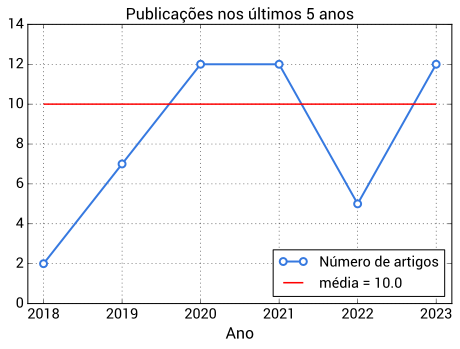

In [131]:
mpl.rc('font', family='Roboto')

year_dic =  OrderedDict(sorted(data_summary.year.items()))
media = sum( data_summary.year.values() ) / 5

mpl.figure( 1, figsize=(1.2*6,1.2*4) )
mpl.plot( year_dic.keys(), year_dic.values(), 'o-',
         linewidth=2, color='#3679e0',
         markersize=7, markerfacecolor='w', markeredgewidth=2,
         markeredgecolor='#3679e0', label='Número de artigos' )
mpl.hlines( media, 2018, 2023, color='r', label=f"média = {media:.1f}" )
mpl.grid()
mpl.xlabel( 'Ano' )
# mpl.ylabel( 'Número of papers' )
mpl.title( "Publicações nos últimos 5 anos" )
mpl.gca().set_axisbelow(True)
mpl.xlim( (2018-0.2, 2023+.2) )
mpl.ylim( (0, 14) )
mpl.legend(loc='lower right')
mpl.gca().set_xticks( range( 2018, 2023+1, 1 ) );
mpl.savefig( 'IDMEC_PubsLast5Years.svg', bbox_inches='tight', pad_inches=0.02 )

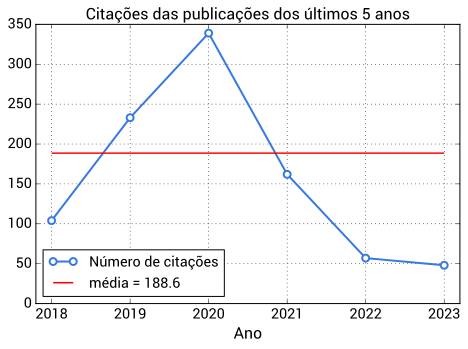

In [135]:
mpl.rc('font', family='Roboto')

year_dic =  OrderedDict(sorted(data_summary.citations.items()))
media = sum( data_summary.citations.values() ) / 5.0

mpl.figure( 1, figsize=(1.2*6,1.2*4) )
mpl.plot( year_dic.keys(), year_dic.values(), 'o-',
         linewidth=2, color='#3679e0',
         markersize=7, markerfacecolor='w', markeredgewidth=2,
         markeredgecolor='#3679e0', label='Número de citações' )
mpl.hlines( media, 2018, 2023, color='r', label=f"média = {media:.1f}" )
mpl.xlim( (2018-0.2, 2023+.2) )
mpl.ylim( (0, 350) )
mpl.legend(loc='lower left')
mpl.grid()
mpl.xlabel( 'Ano' )
mpl.title( "Citações das publicações dos últimos 5 anos" )
mpl.gca().set_axisbelow(True)
mpl.savefig( 'IDMEC_Citations_PubsLast5Years.svg', bbox_inches='tight', pad_inches=0.02 )